<a href="https://colab.research.google.com/github/narim08/Artificial-Intelligence/blob/main/2022202065_AI_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
from pickle import TRUE
class PCA:
    def __init__(self, n_components, whiten, random_state=41, gram_iter=15):
        self.n_components = n_components
        self.whiten = whiten
        self.gram_iter = gram_iter


    def covariance(self, Z):
        cov = np.dot(Z.T, Z) / (Z.shape[0]-1) #Covariance Matrix 계산

        return cov


    def whitening(self, X):
        X_std = np.std(X, axis=0)             #각 열의 표준편차 계산
        X_std[X_std==0] = 1                   #표준편차가 0인 경우 차원 변화 없음
        whitened_data = X / X_std

        return whitened_data


    def gram_schmidt(self, A):   #고유값 분해를 QR분해로 구현(Gram-schmidt process)
        m, n = A.shape
        Q = np.zeros((m, n))                  #직교 벡터 행렬
        R = np.zeros((n, n))                  #상삼각 행렬

        for j in tqdm(range(n)):
          v = A[:, j]                         #A의 열벡터 초기 설정

          for i in range(j):     #이전 열벡터들에 정사영한 벡터를 그 크기만큼 뺌
            R[i, j] = np.dot(Q[:, i], v) #Q의 i번째 벡터에 대한 정사영 개수
            v -= R[i, j] * Q[:, i]          #정사영만큼 v벡터에서 뺌

          R[j, j] = np.linalg.norm(v)          #직교 벡터 크기
          if R[j, j] > 1e-10:
            Q[:, j] = v / R[j, j]              #정규 직교화 벡터
          else:
            Q[:, j] = np.zeros(m)              #선형종속이면 0 벡터


        return Q, R


    def eig(self, A):
        n = A.shape[0]                         #공분산행렬의 크기
        Q_vectors = np.eye(n)                  #고유벡터 저장 행렬
        newCov = A.copy()                      #공분산행렬 업데이트용

        epsilon = 1e-8                         #수렴 조건을 위한 작은 값
        for _ in range(self.gram_iter):        #newCov를 대각 행렬에 수렴할때까지 반복
          Q, R = self.gram_schmidt(newCov)     #QR 분해
          newCov_next = np.dot(R, Q)           #R*Q로 치환

          if np.linalg.norm(newCov - newCov_next) < epsilon:
            break

          newCov = newCov_next
          Q_vectors = np.dot(Q_vectors, Q)     #Q행렬 누적

        eigvalues = np.diag(newCov)            #고유값: 공분산행렬의 대각성분
        eigvectors = Q_vectors                 #고유벡터: Q행렬

        return eigvalues, eigvectors


    def fit(self, data):
        #1. Normalization of Data
        data_mean = np.mean(data, axis=0)        #각 열의 평균값 계산
        data_normal = data - data_mean           #정규화 (X-u)

        if self.whiten:
          data_normal = self.whitening(data_normal)   #whitening 적용

        #2. Covariance Matrix Computation
        cov = self.covariance(data_normal)

        #3. Eigenvalue Decomposition of Covariance Matrix
        eigvalues, eigvectors = self.eig(cov)

        #4. Selection of Principal Components
        n = np.argsort(eigvalues)[::-1]          #고유값 내림차순 정렬
        first_eigvectors = eigvectors[:, n[:self.n_components]]

        #5. Transformation of Data
        pca_output = np.dot(data_normal, first_eigvectors)

        return pca_output


In [ ]:
people = fetch_lfw_people(min_faces_per_person=100, resize=0.5)
image_shape = people.images[0].shape
print("dataset keys        : ", people.keys())
print("dataset.images shape: ", people.images.shape)
print("dataset.data shape  : ", people.data.shape)
print("dataset.target shape: ", people.target.shape)

dataset keys        :  dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
dataset.images shape:  (1140, 62, 47)
dataset.data shape  :  (1140, 2914)
dataset.target shape:  (1140,)


In [ ]:
pca = PCA(200, False)
n_component_data = pca.fit(people.data)
pca_w = PCA(200, True)
n_component_data_w = pca_w.fit(people.data)
X_train, X_test, y_train, y_test = train_test_split(n_component_data, people.target, test_size=0.25, random_state=41)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(n_component_data_w, people.target, test_size=0.25, random_state=41)

100%|██████████| 2914/2914 [05:36<00:00,  8.65it/s]


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.model_selection import train_test_split

import numpy as np

In [ ]:
x_people_scaled = n_component_data
y_people = people.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_people_scaled, y_people, #분할할 데이터
                                                    stratify=y_people, random_state=0) #그룹화할 데이터, 랜덤상태

In [ ]:
knn = knc(n_neighbors=1) #이웃의 수
knn_w = knc(n_neighbors=1)

In [ ]:
knn.fit(X_train, y_train) # 모델 학습
knn_w.fit(X_train_w, y_train_w)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_pred = knn.predict(X_test) #예측 수행
y_pred_w = knn_w.predict(X_test_w)

# Results
#### -F1 score를 각 채점 항목 별로 출력하면 됩니다

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
print(f"Naive PCA: {f1_score(y_test, y_pred, average='weighted')}\nWhitening PCA: {f1_score(y_test_w, y_pred_w, average='weighted')}")

Naive PCA: 0.5948460048227809
Whitening PCA: 0.6149155553859792


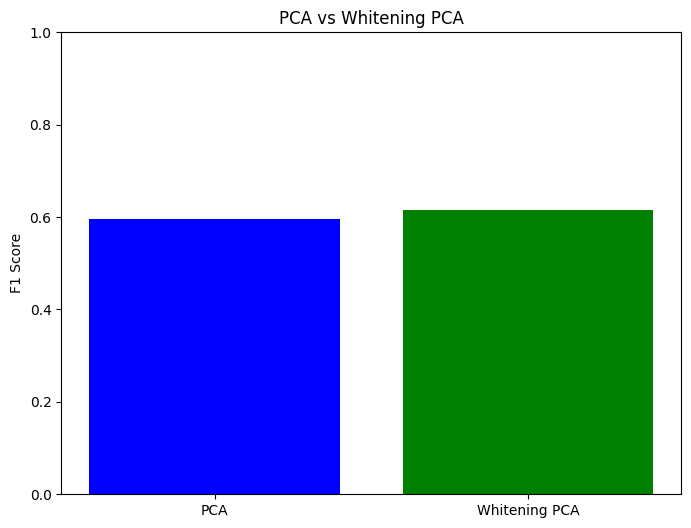

In [ ]:
import matplotlib.pyplot as plt

f1_scores = [0.5948460048227809, 0.6149155553859792]  # Naive PCA, Whitening PCA
models = ['PCA', 'Whitening PCA']

# 막대 그래프
plt.figure(figsize=(8, 6))
plt.bar(models, f1_scores, color=['blue', 'green'])
plt.ylim(0.0, 1.0)  # y축 범위 설정 (0.5 ~ 0.65)
plt.ylabel('F1 Score')
plt.title('PCA vs Whitening PCA')
plt.show()
